In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dataloader import *
import os
from tqdm import tqdm

In [2]:
d =  DataGenerator(dataset_csv='/home/mendeza/Documents/dataset_10_31_2020_3903_clustered.csv',
                   pano_directory='/home/mendeza/Documents/data2/pano_image',
                   label_directory='/home/mendeza/Documents/data2/labels',
                   num_classes=1,
                   num_samples_per_class=2*2,
                   num_meta_test_classes=1,
                   num_meta_test_samples_per_class=3*2,#3-shot test
                   IMG_WIDTH=256,
                   IMG_HEIGHT=256,
                   num_circles=3)


In [3]:

images,labels = d.sample_batch('meta_train',16)
print(images.shape)
print(labels.shape)

(16, 1, 4, 256, 256, 3)
(16, 1, 4, 256, 256, 1)


In [4]:
images[0][0].shape

(4, 256, 256, 3)

In [4]:
from segmentation_models import Unet
import segmentation_models as sm
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.losses import bce_dice_loss
from segmentation_models.metrics import iou_score


BACKBONE='mobilenet'
preprocess_input = get_preprocessing(BACKBONE)
# model = Unet(BACKBONE, encoder_weights='imagenet')

Segmentation Models: using `tf.keras` framework.


In [63]:
# model.m.layers[2].bias

In [5]:
def get_unet(img_rows,img_cols):
    inputs = tf.keras.layers.Input((img_rows, img_cols, 3))
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 =tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 =tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 =tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 =tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 =tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    # model.compile(optimizer=tfAdam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [17]:
m=get_unet(224,224)

In [7]:
# for layer in model.trainable_weights:
#     print(layer.name,layer.shape)
    # print(w.shape)

In [7]:
# for layer in model.trainable_weights:
#     print(layer.name,layer.shape)

In [9]:
# model.m.layers[2].weights

In [6]:
from segmentation_models import Unet
import segmentation_models as sm
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.losses import bce_dice_loss
from segmentation_models.metrics import iou_score
preprocess_input = get_preprocessing('mobilenet')
from functools import partial

def copy_model_fn(mi):
    copied_model = get_unet(224,224)
    copied_model.set_weights(mi.get_weights())
    return copied_model

class MAML_UNet(tf.keras.Model):
    def __init__(self,
                 model_weights,
                 dim_input=1,
                 dim_output=1,
                 num_inner_updates=1,
                 inner_update_lr=0.4,
                 k_shot=5,
                 backbone='mobilenet',
                 pretrain=False):
        '''
        '''
        super(tf.keras.Model, self).__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.inner_update_lr = inner_update_lr
        self.get_preprocessing = get_preprocessing
        self.iou_score = iou_score
        self.BACKBONE = backbone
        self.pretrain = pretrain
        self.loss_func = bce_jaccard_loss
        self.preprocess_input = get_preprocessing(self.BACKBONE)
        if self.pretrain:
            self.m = get_unet(224,224)
        else:
            self.m = get_unet(224,224)


        # outputs_ts[i] and losses_ts_post[i] are the output and loss after i+1 inner gradient updates
        losses_tr_pre, outputs_tr, losses_ts_post, outputs_ts = [], [], [], []
        accuracies_tr_pre, accuracies_ts = [], []

        # for each loop in the inner training loop
        outputs_ts = [[]]*num_inner_updates
        losses_ts_post = [[]]*num_inner_updates
        accuracies_ts = [[]]*num_inner_updates

        self.w = self.m.trainable_weights
    # @tf.function
    def call(self,
             inp,
             meta_batch_size=25,
             num_inner_updates=1):
        def task_inner_loop(inp,reuse=True,meta_batch_size=25,num_inner_updates=1):
            '''
            '''
            # the inner and outer loop data
            # query set: (input_tr,label_tr)
            input_tr, input_ts, label_tr, label_ts = inp

            # weights corresponds to the initial weights in MAML (i.e. the meta-parameters)
            # weights = self.w

            # the predicted outputs, loss values, and accuracy for the pre-update model (with the initial weights)
            # evaluated on the inner loop training data
            task_output_tr_pre, task_loss_tr_pre, task_accuracy_tr_pre = None, None, None

            # lists to keep track of outputs, losses, and accuracies of test data for each inner_update
            # where task_outputs_ts[i], task_losses_ts[i], task_accuracies_ts[i] are the output, loss, and accuracy
            # after i+1 inner gradient updates
            task_outputs_ts, task_losses_ts, task_accuracies_ts = [], [], []
            # model = Unet(self.BACKBONE, encoder_weights=None)
            # for i in range(len(model.trainable_weights)):
            #     model.trainable_weights[i].assign(weights[i])
                
            # model = copy_model_fn(self.m,input_tr) 
            # model(input_tr)
            # copy_model(input_tr)
            ######################################
            ############### MAML #################
            with tf.GradientTape(persistent=True) as tape:
                # print(input_tr.shape)
                # tape.watch(model.trainable_weights)
                copied_model = copy_model_fn(self.m)
                task_output_tr_pre = copied_model(input_tr)# logits
                task_loss_tr_pre = self.loss_func(label_tr,task_output_tr_pre)
                grads = tape.gradient(task_loss_tr_pre,copied_model.trainable_weights)
                k=0
                for j in range(len(self.m.layers)):
                    # print(j,m.layers[j].name,copied_model.layers[j].name)
                    
                    if j not in [0,3,6,9,12,16,20,24,28]:
                        # print(j,copied_model.layers[j].name)
                        # print(j,k,copied_model.layers[j].kernel.shape,m.layers[j].kernel.shape,grads[k].shape)
                        # print(j,k+1,copied_model.layers[j].bias.shape,m.layers[j].bias.shape,grads[k+1].shape)
                        # print(j,copied_model.layers[j].bias.name,copied_model.layers[j].bias.shape)
                        # print(j,copied_model.layers[j].kernel.name,m.layers[j].kernel.shape)
                        # print(grads[k].shape)
                        copied_model.layers[j].kernel = self.m.layers[j].kernel - self.inner_update_lr*grads[k]
                        copied_model.layers[j].bias = self.m.layers[j].bias - self.inner_update_lr*grads[k+1]
                        k+=2

                output_ts = copied_model(input_ts)
                loss_ts = self.loss_func(label_ts,output_ts)

                task_outputs_ts.append(output_ts)
                # print("task_outputs_ts {}".format(task_outputs_ts))#(B,5)
                task_losses_ts.append(loss_ts)
                # if num_inner_updates > 1:
                    # NOTE(ANDREW): tf.keras hack does not work for multiple gradient updates
                    # model.set_weights(fast_weights)
                    # for update in range(num_inner_updates-1):
                    #     outputt = copy_model(input_tr,training=True)
                    #     losss = self.loss_func(label_tr,outputt)
                    #     grads = tape.gradient(losss,copy_model.trainable_weights)

                    #     for j in range(len(model.trainable_weights)):
                    #         copy_model.trainable_weights[j] = copy_model.trainable_weights[j] - self.inner_update_lr*grads[j]
                        
                    #     outputtt = copy_model(input_ts,training=True)
                    #     task_outputs_ts.append(outputtt)
                    #     task_losses_ts.append(self.loss_func(label_ts,outputtt))
            # Compute accuracies from output predictions
            task_accuracy_tr_pre = self.iou_score(label_tr,task_output_tr_pre)

            for j in range(num_inner_updates):
                task_accuracies_ts.append(self.iou_score(label_ts,task_outputs_ts[j]))

            task_output = [task_output_tr_pre, task_outputs_ts, task_loss_tr_pre, task_losses_ts, task_accuracy_tr_pre, task_accuracies_ts]

            return task_output

        out_dtype = [tf.float32, [tf.float32]*num_inner_updates, tf.float32, [tf.float32]*num_inner_updates]
        out_dtype.extend([tf.float32, [tf.float32]*num_inner_updates])
        task_inner_loop_partial = partial(task_inner_loop, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)
        result = tf.map_fn(task_inner_loop_partial,
                        elems=(input_tr, input_ts, label_tr, label_ts),
                        dtype=out_dtype,
                        parallel_iterations=meta_batch_size)
        return result





        

In [7]:
 model = MAML_UNet(None,
                 dim_input=1,
                 dim_output=1,
                 num_inner_updates=1,
                 inner_update_lr=0.4,
                 k_shot=5,
                 backbone='mobilenet',
                 pretrain=False)

In [8]:
# images,
k_shot=2
images,labels = d.sample_batch('meta_train',8)
b,n,k,w,h,c = images.shape
print(b,n,k,w,h,c)
images = images.reshape((b,n*k,w,h,c))
print("images: {}".format(images.shape))
labels = labels.reshape((b,n*k,w,h,1))

input_tr  = images[:,:k_shot]
label_tr = labels[:,:k_shot]
input_ts = images[:,k_shot:]
label_ts = labels[:,k_shot:]

input_tr = preprocess_input(input_tr)
input_tr = tf.convert_to_tensor(input_tr,tf.float32)
input_ts = preprocess_input(input_ts)
input_ts = tf.convert_to_tensor(input_ts,tf.float32)

label_tr = tf.convert_to_tensor(label_tr,tf.float32)
label_ts = tf.convert_to_tensor(label_ts,tf.float32)
inp = (input_tr, input_ts, label_tr, label_ts)
# result = model(inp, meta_batch_size=16, num_inner_updates=1)

8 1 4 256 256 3
images: (8, 4, 256, 256, 3)


In [9]:
# model.m.trainable_variables
from time import time

In [10]:

def outer_train_step(inp, model, optim, meta_batch_size=25, num_inner_updates=1):
  # note here, outer tape constructed to watch all model.trainable_variables!
  # inner_loop is called in model(...)
  # no need to do persistent, since only 1 outer_tape.gradient needs to be called
  with tf.GradientTape(persistent=False) as outer_tape:
    result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

    outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

    total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]
  # dont need to update self.inner_update_lr_dict,
  # since learn rate is part of the model.training_variables
  gradients = outer_tape.gradient(total_losses_ts[-1], model.m.trainable_weights)
  # this will update ALL PARAMETERS, including the LEARN RATE!
  # rather than manual gradient descent, Adam (adaptive grad descent) used to update params
  optim.apply_gradients(zip(gradients, model.m.trainable_weights))

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

def outer_eval_step(inp, model, meta_batch_size=25, num_inner_updates=1):
  result = model(inp, meta_batch_size=meta_batch_size, num_inner_updates=num_inner_updates)

  outputs_tr, outputs_ts, losses_tr_pre, losses_ts, accuracies_tr_pre, accuracies_ts = result

  total_loss_tr_pre = tf.reduce_mean(losses_tr_pre)
  total_losses_ts = [tf.reduce_mean(loss_ts) for loss_ts in losses_ts]

  total_accuracy_tr_pre = tf.reduce_mean(accuracies_tr_pre)
  total_accuracies_ts = [tf.reduce_mean(accuracy_ts) for accuracy_ts in accuracies_ts]

  return outputs_tr, outputs_ts, total_loss_tr_pre, total_losses_ts, total_accuracy_tr_pre, total_accuracies_ts

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# t0 = time()
# result = outer_train_step(inp, model, optimizer, meta_batch_size=8, num_inner_updates=1)
# print("Time: {}".format(time()-t0))

In [14]:
from tqdm import tqdm
pre_accuracies, post_accuracies = [], []
val_post_accs = []
SUMMARY_INTERVAL = 2
SAVE_INTERVAL = 5
PRINT_INTERVAL = 10
# TEST_PRINT_INTERVAL = PRINT_INTERVAL*5
TEST_PRINT_INTERVAL = 10

batch_size = 8
num_inner_updates = 1
meta_train_iterations = 3000
for itr in tqdm(range(meta_train_iterations)):

    k_shot=2
    images,labels = d.sample_batch('meta_train',batch_size)
    b,n,k,w,h,c = images.shape
    print(b,n,k,w,h,c)
    images = images.reshape((b,n*k,w,h,c))
    # print("images: {}".format(images.shape))
    labels = labels.reshape((b,n*k,w,h,1))

    input_tr  = images[:,:k_shot]
    label_tr = labels[:,:k_shot]
    input_ts = images[:,k_shot:]
    label_ts = labels[:,k_shot:]

    input_tr = preprocess_input(input_tr)
    input_tr = tf.convert_to_tensor(input_tr,tf.float32)
    input_ts = preprocess_input(input_ts)
    input_ts = tf.convert_to_tensor(input_ts,tf.float32)

    label_tr = tf.convert_to_tensor(label_tr,tf.float32)
    label_ts = tf.convert_to_tensor(label_ts,tf.float32)
    inp = (input_tr, input_ts, label_tr, label_ts)

    result = outer_train_step(inp, model, optimizer, meta_batch_size=batch_size, num_inner_updates=num_inner_updates)
    if itr % SUMMARY_INTERVAL == 0:
      pre_accuracies.append(result[-2])
      post_accuracies.append(result[-1][-1])

    if (itr!=0) and itr % PRINT_INTERVAL == 0:
      print_str = 'Iteration %d: pre-inner-loop train accuracy: %.5f, post-inner-loop test accuracy: %.5f' % (itr, np.mean(pre_accuracies), np.mean(post_accuracies))
      print(print_str)
      # pre_accuracies, post_accuracies = [], []
    if (itr!=0) and itr % TEST_PRINT_INTERVAL == 0:
        k_shot=2
        images,labels = d.sample_batch('meta_eval',batch_size)
        b,n,k,w,h,c = images.shape
        print(b,n,k,w,h,c)
        images = images.reshape((b,n*k,w,h,c))
        # print("images: {}".format(images.shape))
        labels = labels.reshape((b,n*k,w,h,1))

        input_tr  = images[:,:k_shot]
        label_tr = labels[:,:k_shot]
        input_ts = images[:,k_shot:]
        label_ts = labels[:,k_shot:]

        input_tr = preprocess_input(input_tr)
        input_tr = tf.convert_to_tensor(input_tr,tf.float32)
        input_ts = preprocess_input(input_ts)
        input_ts = tf.convert_to_tensor(input_ts,tf.float32)

        label_tr = tf.convert_to_tensor(label_tr,tf.float32)
        label_ts = tf.convert_to_tensor(label_ts,tf.float32)
        inp = (input_tr, input_ts, label_tr, label_ts)
        result = outer_eval_step(inp, model, meta_batch_size=batch_size, num_inner_updates=num_inner_updates)
        val_post_accs.append(result[-1][-1])
        print('Meta-validation pre-inner-loop train accuracy: %.5f, meta-validation post-inner-loop test accuracy: %.5f' % (result[-2], result[-1][-1]))
    # return post_accuracies
#   model_file = '.' + '/' +'model' + str(itr)
#   print("Saving to ", model_file)
#   model.save_weights(model_file)


  0%|          | 10/3000 [00:49<4:21:43,  5.25s/it]8 1 4 256 256 3
Iteration 10: pre-inner-loop train accuracy: 0.02237, post-inner-loop test accuracy: 0.01002
8 1 6 256 256 3
  0%|          | 11/3000 [01:00<5:42:28,  6.87s/it]Meta-validation pre-inner-loop train accuracy: 0.06803, meta-validation post-inner-loop test accuracy: 0.01314
8 1 4 256 256 3
  1%|          | 20/3000 [01:51<5:03:25,  6.11s/it]8 1 4 256 256 3
Iteration 20: pre-inner-loop train accuracy: 0.02106, post-inner-loop test accuracy: 0.01050
8 1 6 256 256 3
  1%|          | 21/3000 [02:03<6:36:00,  7.98s/it]Meta-validation pre-inner-loop train accuracy: 0.04912, meta-validation post-inner-loop test accuracy: 0.02024
8 1 4 256 256 3
  1%|          | 24/3000 [02:39<5:29:43,  6.65s/it]


ResourceExhaustedError: OOM when allocating tensor with shape[512,512,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropFilter]

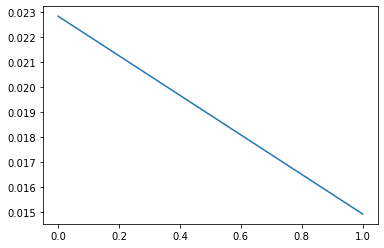

In [12]:
plt.plot(val_post_accs)

In [32]:
result[-1]

[<tf.Tensor: id=3542454, shape=(), dtype=float32, numpy=1.02407665e-08>]

In [6]:
import tensorflow as tf

print(tf.test.is_gpu_available())


True


In [7]:
tf.__version__

'2.0.0'